# フィルタリング

In [1]:
from datasets import load_dataset
from collections import Counter
from pydantic import BaseModel

import numpy as np
import matplotlib.pyplot as plt
from huggingface_hub import login

In [2]:
login()

In [3]:
dataset = load_dataset("Ty-Yuki/SFT_OpenThoughts-114k_no-filter_no-proof")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/457 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/72541 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'output', 'answer', 'domain', 'source'],
        num_rows: 72541
    })
})


In [4]:
def analyze_data(train_dataset):
    # domainごとにsourceを集計
    domain_source_counts = {}
    domain_list = []
    source_list = []

    for item in train_dataset:
        domain = item["domain"]
        source = item["source"]
        domain_list.append(domain)
        source_list.append(source)
        if domain not in domain_source_counts:
            domain_source_counts[domain] = []
        domain_source_counts[domain].append(source)

    # domain全体の割合を計算
    domain_counter = Counter(domain_list)
    total_domains = len(domain_list)

    # source全体の割合を計算
    source_counter = Counter(source_list)
    total_sources = len(source_list)

    # domainごとにsourceの割合を出力（sourceの割合は全体に対するもの）
    for domain, sources in domain_source_counts.items():
        domain_count = domain_counter[domain]
        domain_ratio = domain_count / total_domains * 100
        print(f"{domain}: {domain_count}件 ({domain_ratio:.2f}%)")
        counter = Counter(sources)
        for source, count in counter.items():
            overall_ratio = source_counter[source] / total_sources * 100
            print(f"   {source}: {count}件 ({overall_ratio:.2f}%)")
        print()

analyze_data(dataset["train"])

math: 51057件 (70.38%)
   numina_math: 51057件 (70.38%)

code: 19903件 (27.44%)
   code_contests: 6509件 (8.97%)
   apps: 4794件 (6.61%)
   taco: 6983件 (9.63%)
   codeforces: 1617件 (2.23%)

biology: 26件 (0.04%)
   camelai_biology: 26件 (0.04%)

physics: 288件 (0.40%)
   camelai_physics: 288件 (0.40%)

chemistry: 323件 (0.45%)
   camelai_chemistry: 323件 (0.45%)

puzzle: 944件 (1.30%)
   riddle_sense: 944件 (1.30%)



math: 63905件 (74.84%)
   numina_math: 63905件 (74.84%)

code: 19903件 (23.31%)
   code_contests: 6509件 (7.62%)
   apps: 4794件 (5.61%)
   taco: 6983件 (8.18%)
   codeforces: 1617件 (1.89%)

biology: 26件 (0.03%)
   camelai_biology: 26件 (0.03%)

physics: 288件 (0.34%)
   camelai_physics: 288件 (0.34%)

chemistry: 323件 (0.38%)
   camelai_chemistry: 323件 (0.38%)

puzzle: 944件 (1.11%)
   riddle_sense: 944件 (1.11%)



In [5]:
class FilterJsonModel(BaseModel):
    id: int
    question: str
    output: str
    answer: str


def make_no_filter_jsonl(
    train_dataset,
    # Math = 5000
    numina_math=5000,
    # Code = 300
    code_contests=100,
    apps=70,
    taco=100,
    codeforces=30,
    # Science = 400
    camelai_biology=25,
    camelai_physics=200,
    camelai_chemistry=175,
    # Puzzle = 300
    riddle_sense=300,
    weight_power = 4,
    jsonl_path="filter.jsonl",
):
    source_dict = {
        "numina_math": numina_math,
        "code_contests": code_contests,
        "apps": apps,
        "taco": taco,
        "codeforces": codeforces,
        "camelai_biology": camelai_biology,
        "camelai_physics": camelai_physics,
        "camelai_chemistry": camelai_chemistry,
        "riddle_sense": riddle_sense,
    }
    id = 0
    json_list = []

    for source, n_samples in source_dict.items():
        source_dataset = train_dataset.filter(lambda example: example["source"] == source)

        lengths = np.array([len(x) for x in source_dataset["output"]])

        weights = (lengths/1e-5) ** weight_power
        weights = weights / weights.sum()
        indices = np.random.choice(len(source_dataset), size=n_samples, replace=False, p=weights)
        samples = [source_dataset[int(i)] for i in indices]
        samples_lengths = np.array([len(sample["output"]) for sample in samples])


        for sample in samples:
            json = FilterJsonModel(
                id=id,
                question=sample["question"],
                output=sample["output"],
                answer=sample["answer"],
            )
            json_list.append(json)
            id += 1

        bins = np.linspace(0, np.max(lengths), 20)
        plt.hist(lengths, bins=bins, alpha=0.5, label='origin', edgecolor='black')
        plt.hist(samples_lengths, bins=bins, alpha=0.5, label='samples', edgecolor='black')
        plt.title(source)
        plt.legend()
        plt.show()

    with open(jsonl_path, "w") as f:
        for json_data in json_list:
            json_str = json_data.model_dump_json()
            f.write(json_str + "\n")

Filter:   0%|          | 0/72541 [00:00<?, ? examples/s]

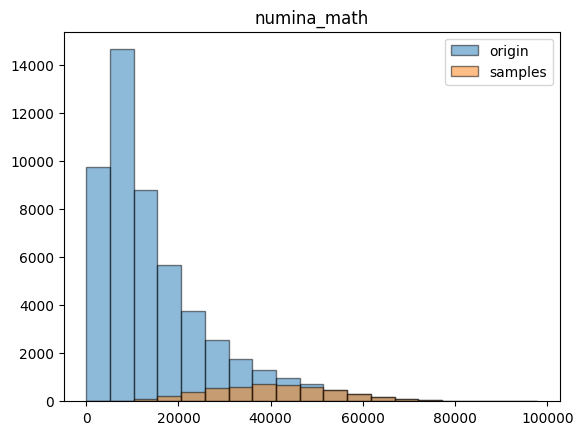

Filter:   0%|          | 0/72541 [00:00<?, ? examples/s]

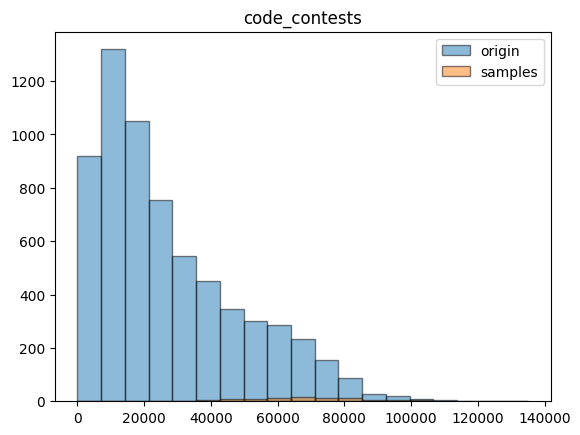

Filter:   0%|          | 0/72541 [00:00<?, ? examples/s]

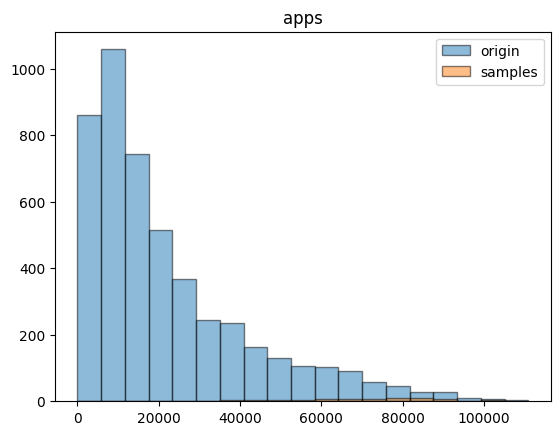

Filter:   0%|          | 0/72541 [00:00<?, ? examples/s]

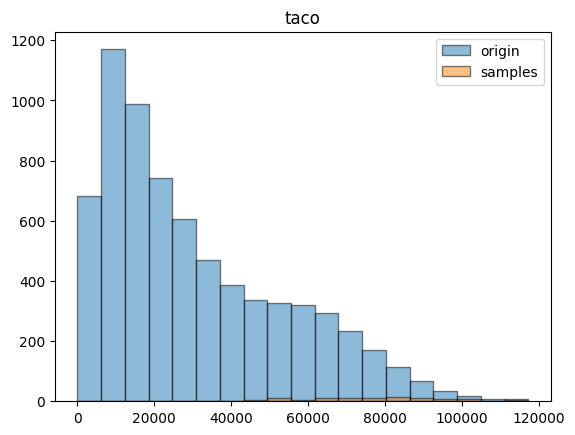

Filter:   0%|          | 0/72541 [00:00<?, ? examples/s]

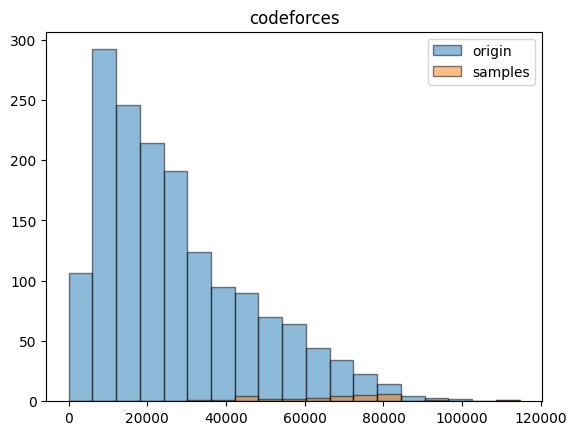

Filter:   0%|          | 0/72541 [00:00<?, ? examples/s]

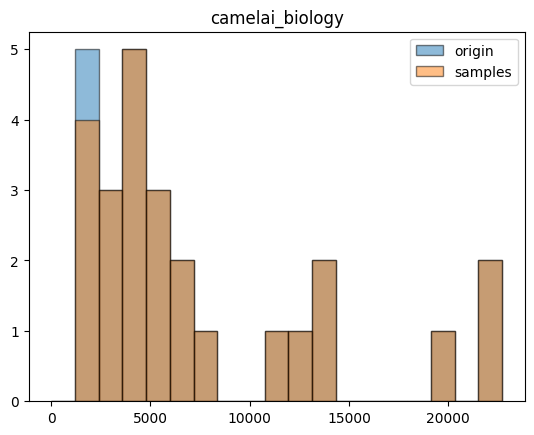

Filter:   0%|          | 0/72541 [00:00<?, ? examples/s]

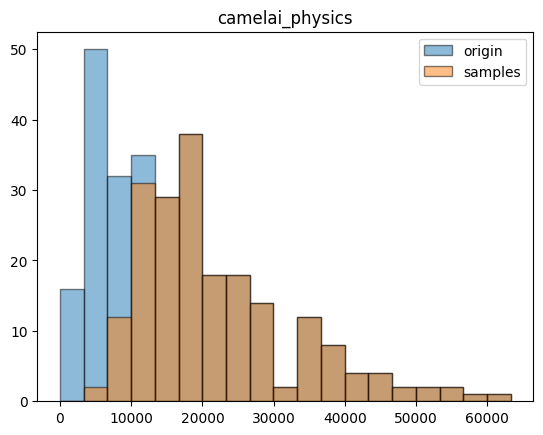

Filter:   0%|          | 0/72541 [00:00<?, ? examples/s]

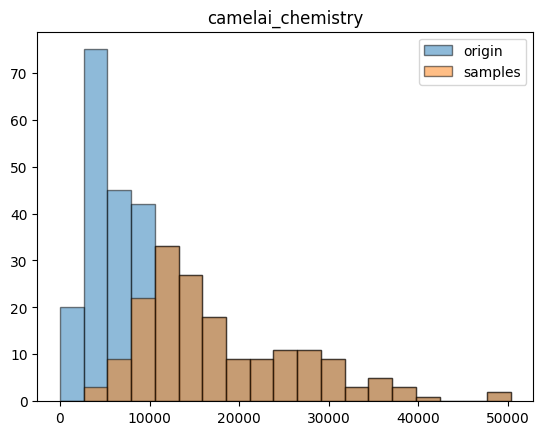

Filter:   0%|          | 0/72541 [00:00<?, ? examples/s]

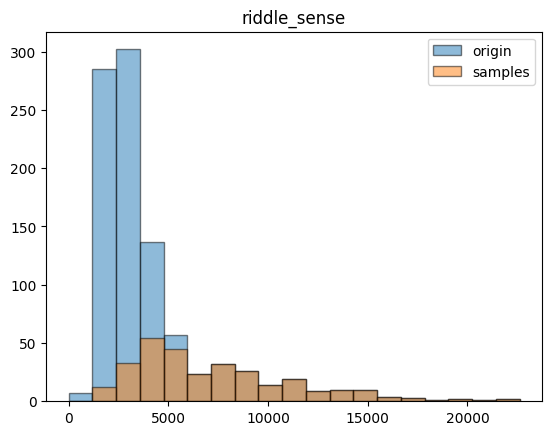

In [6]:
make_no_filter_jsonl(dataset["train"])

In [8]:
dataset = load_dataset("json", data_files="filter.jsonl", split="train")
dataset.push_to_hub("neko-llm/HLE_SFT_OpenThoughts-114k")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|          |  524kB /  102MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/neko-llm/HLE_SFT_OpenThoughts-114k/commit/9f45091fc98a2658b807ae266025d202976d0096', commit_message='Upload dataset', commit_description='', oid='9f45091fc98a2658b807ae266025d202976d0096', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/neko-llm/HLE_SFT_OpenThoughts-114k', endpoint='https://huggingface.co', repo_type='dataset', repo_id='neko-llm/HLE_SFT_OpenThoughts-114k'), pr_revision=None, pr_num=None)